overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from IPython.display import display

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200515 as param_iterator_obj,
    keygen,
    encode_transfer_learning_cb19_params, decode_transfer_learning_cb19_params
)

from thesis_v2.training_extra.data import generate_datasets

In [5]:
# compute ccmax
from strflab.stats import cc_max

def get_cc_max_8k():
    from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

    cc_max_all_neurons = cc_max(get_neural_data_per_trial(
        ('042318', '043018','051018',))
                               )
    assert cc_max_all_neurons.shape == (79,)
    
    return cc_max_all_neurons

def get_cc_max_cb19():
    from thesis_v2.data.prepared.cadena_plos_cb19 import get_neural_data_per_trial

    cc_max_all_neurons = cc_max(get_neural_data_per_trial(fill_value='zero'))
    assert cc_max_all_neurons.shape == (115,)
    
    return cc_max_all_neurons

In [6]:
from torch.backends import cudnn
from torch import nn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()
_data_cache_cb19 = dict()
def get_data_cached(input_size, seed):
    from thesis_v2.data.prepared.yuanyuan_8k import get_data
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]



def get_data_cached_cb19(px_kept, input_size, seed):
    from thesis_v2.data.prepared.cadena_plos_cb19 import get_data
    if (px_kept, input_size, seed) not in _data_cache_cb19:
        _data_cache_cb19[px_kept, input_size, seed] = get_data(px_kept=px_kept, final_size=input_size, seed=seed, scale=0.5, force_resize=True)
    return _data_cache_cb19[px_kept, input_size, seed]


In [7]:
def get_data_wrapper_8k(param):
    datasets = get_data_cached(param['input_size'], param['split_seed'])
    datasets = {
        'X_train': datasets[0].astype(np.float32),
        'y_train': datasets[1],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }
    
    datasets_all = generate_datasets(
        **datasets,
        per_epoch_train=False,
        shuffle_train=False,
    )
    
    return datasets_all['test']


def get_data_wrapper_cb19(param):
    
    datasets = get_data_cached_cb19(param['cb19_px_kept'], param['input_size'], param['cb19_split_seed'])
    datasets = {
        'X_train': datasets[0].astype(np.float32),
        'y_train': datasets[1],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }
    
    datasets_all = generate_datasets(
        **datasets,
        per_epoch_train=False,
        shuffle_train=False,
    )
    
    return datasets_all['test']

from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper

In [8]:
class SlicedModel(nn.Module):
    def __init__(self, model, slice_this):
        super().__init__()
        self.model = model
        self.slice = slice_this
#         print(self.slice)
    
    def forward(self, *inputs):
        output = self.model(*inputs)
        assert (len(output) == 1)
        return (output[0][:, :, self.slice],)
    
def load_everything():
    
    cc_max_all_8k = get_cc_max_8k()
    cc_max_all_cb19 = get_cc_max_cb19()
    
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue

#         if len(param) == 22:
#             param['train_keep'] = None
        assert len(param) == 26
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        
        params_encoded = encode_transfer_learning_cb19_params(param)
        key = keygen(**{k: v for k, v in params_encoded.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79 + 115,)
        cc_raw_8k = cc_raw[:79]
        cc_raw_cb19 = cc_raw[79:]
        
#         if param['train_keep'] is None:
#             param['train_keep'] = 5120

        # double check 
        datasets_8k_test = get_data_wrapper_8k(param)
        
        result_on_the_go_8k = eval_wrapper(SlicedModel(result['model'].cuda(), slice(79)),
                                            datasets_8k_test,
                                            'cuda',
                                            1,
                                            partial(eval_fn_wrapper_neural, loss_type=param['loss_type'], yhat_reduce_axis=1),
                                            (lambda dummy1,dummy2,dummy3: torch.tensor(0.0)),
                                            return_responses=True
                                           )
        
        
        assert abs(result_on_the_go_8k['corr_mean'] - cc_raw_8k.mean()) < 1e-5
        
        datasets_cb19_test = get_data_wrapper_cb19(param)
        
        result_on_the_go_cb19 = eval_wrapper(SlicedModel(result['model'].cuda(), slice(79,None)),
                                            datasets_cb19_test,
                                            'cuda',
                                            1,
                                            partial(eval_fn_wrapper_neural, loss_type=param['loss_type'], yhat_reduce_axis=1),
                                            (lambda dummy1,dummy2,dummy3: torch.tensor(0.0)),
                                            return_responses=True
                                           )
        
        assert abs(result_on_the_go_cb19['corr_mean'] - cc_raw_cb19.mean()) < 1e-5
        
        
#         print('aaaa')
#         raise RuntimeError
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                'cb19_px_kept': param['cb19_px_kept'],
                # done,
                'corr_test_8k': ((cc_raw_8k/cc_max_all_8k)**2).mean(),
                'corr_test_cb19': ((cc_raw_cb19/cc_max_all_cb19)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'cb19_px_kept',

        'corr_test_8k',
        'corr_test_cb19',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'cb19_px_kept',
    ], verify_integrity=True)
    return _df

In [9]:
df = load_everything()

0
use resize; not optimal for image quality
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [10]:
corr_mean_8k = df['corr_test_8k'].unstack('model_seed').mean(axis=1)
corr_mean_cb19 = df['corr_test_cb19'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [11]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [12]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.011159605206617509 sem 0.0015442483131700943
3 - 2 mean 0.002342484175372026 sem 0.0012951229601380822
4 - 3 mean -0.001671836844116791 sem 0.0011760791341362228
4 - 2 mean 0.000670647331255235 sem 0.0014030290803968498


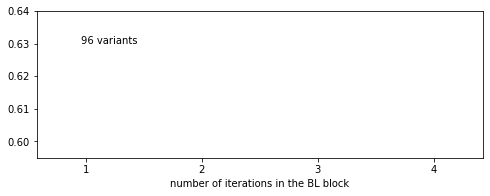

[0.526146104125608, 0.5373057093322254, 0.5396481935075975, 0.5379763566634806] [ 2.12100881  0.4359686  -0.30980125]


,num_of_cycles,performance,gain %
0,1,0.526146,NaN
1,2,0.537306,2.121009
2,3,0.539648,0.435969
3,4,0.537976,-0.309801


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.011312527213785875 sem 0.002341331364744319
3 - 2 mean 0.004418857360990882 sem 0.0018448347043038883
4 - 3 mean -0.0033646733612288948 sem 0.001398234259704976
4 - 2 mean 0.0010541839997619876 sem 0.0016144584211261216


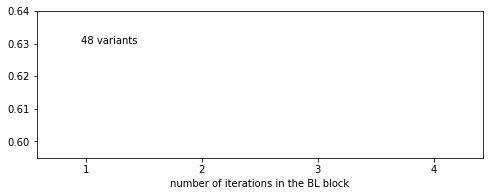

[0.5312371573319564, 0.5425496845457424, 0.5469685419067333, 0.5436038685455044] [ 2.12946837  0.81446133 -0.61514934]


,num_of_cycles,performance,gain %
0,1,0.531237,NaN
1,2,0.542550,2.129468
2,3,0.546969,0.814461
3,4,0.543604,-0.615149


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.011006683199449141 sem 0.0020139524499189106
3 - 2 mean 0.0002661109897531694 sem 0.0017681403435215273
4 - 3 mean 2.0999672995312968e-05 sem 0.0018596197180929751
4 - 2 mean 0.0002871106627484824 sem 0.0022937648584531976


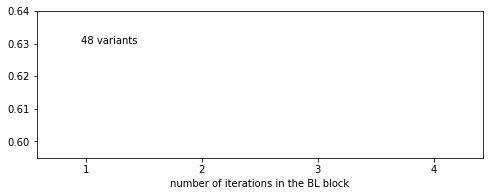

[0.5210550509192595, 0.5320617341187086, 0.5323278451084618, 0.5323488447814572] [2.11238394 0.05001506 0.00394488]


,num_of_cycles,performance,gain %
0,1,0.521055,NaN
1,2,0.532062,2.112384
2,3,0.532328,0.050015
3,4,0.532349,0.003945


In [13]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8, f'{n} variants', verticalalignment='center', horizontalalignment='left', transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    display(pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    ))
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean_8k.xs('full', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))
plot_step_increase(corr_mean_8k.xs('full', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))
plot_step_increase(corr_mean_8k.xs('full', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.015237479690818822 sem 0.002032507309467084
3 - 2 mean 0.00088491870007567 sem 0.0012280503344735052
4 - 3 mean -0.00037368228407220865 sem 0.0013953300564499
4 - 2 mean 0.0005112364160034614 sem 0.0014948974539313925


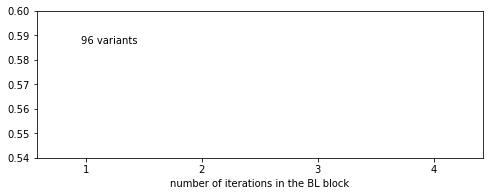

[0.44439647330364035, 0.45963395299445925, 0.4605188716945349, 0.4601451894104627] [ 3.42880302  0.19252683 -0.08114375]


,num_of_cycles,performance,gain %
0,1,0.444396,NaN
1,2,0.459634,3.428803
2,3,0.460519,0.192527
3,4,0.460145,-0.081144


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.016637875216165905 sem 0.0027657406165490332
3 - 2 mean 0.0007409422022727659 sem 0.0017284707289451301
4 - 3 mean 0.0017464480496744126 sem 0.0017817053049787898
4 - 2 mean 0.0024873902519471787 sem 0.001566967240993125


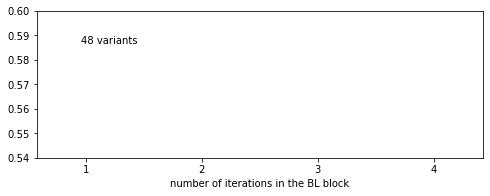

[0.4514507032130985, 0.4680885784292643, 0.4688295206315371, 0.4705759686812115] [3.68542459 0.15829102 0.37251239]


,num_of_cycles,performance,gain %
0,1,0.451451,NaN
1,2,0.468089,3.685425
2,3,0.468830,0.158291
3,4,0.470576,0.372512


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.013837084165471742 sem 0.0029653515603230976
3 - 2 mean 0.0010288951978785741 sem 0.0017446935883372735
4 - 3 mean -0.00249381261781883 sem 0.0021038109180573565
4 - 2 mean -0.0014649174199402558 sem 0.0025141144081826986


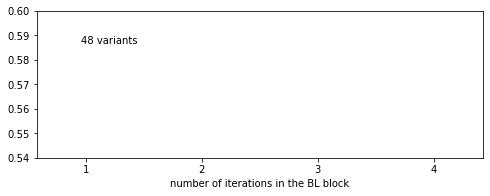

[0.43734224339418243, 0.45117932755965406, 0.45220822275753275, 0.4497144101397139] [ 3.16390296  0.22804573 -0.55147441]


,num_of_cycles,performance,gain %
0,1,0.437342,NaN
1,2,0.451179,3.163903
2,3,0.452208,0.228046
3,4,0.449714,-0.551474


In [14]:
plot_step_increase(corr_mean_8k.xs('half', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))
plot_step_increase(corr_mean_8k.xs('half', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))
plot_step_increase(corr_mean_8k.xs('half', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))



(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.004063156880513649 sem 0.0035149783187716846
3 - 2 mean 0.012297761750867433 sem 0.0028352108950529934
4 - 3 mean 0.005933113328517341 sem 0.0025838580755868285
4 - 2 mean 0.018230875079384774 sem 0.003463060248288423


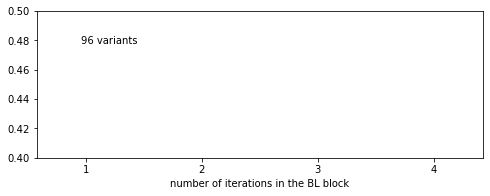

[0.2590886509800537, 0.2631518078605674, 0.2754495696114348, 0.28138268293995217] [1.56824966 4.67325756 2.15397444]


,num_of_cycles,performance,gain %
0,1,0.259089,NaN
1,2,0.263152,1.568250
2,3,0.275450,4.673258
3,4,0.281383,2.153974


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.002620009472192985 sem 0.00582927687137731
3 - 2 mean 0.013577436585202054 sem 0.003901249260759316
4 - 3 mean 0.0045248632578495955 sem 0.0030919289103568323
4 - 2 mean 0.018102299843051648 sem 0.004079297703840803


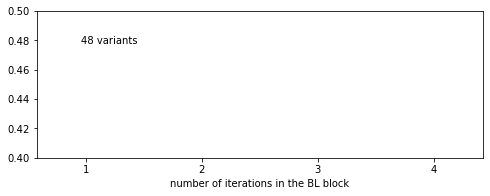

[0.2586406792988886, 0.2612606887710816, 0.27483812535628366, 0.2793629886141333] [1.01299203 5.19689229 1.64637393]


,num_of_cycles,performance,gain %
0,1,0.258641,NaN
1,2,0.261261,1.012992
2,3,0.274838,5.196892
3,4,0.279363,1.646374


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.005506304288834313 sem 0.003918295979224859
3 - 2 mean 0.011018086916532813 sem 0.004106787734519415
4 - 3 mean 0.007341363399185085 sem 0.004130694108924475
4 - 2 mean 0.018359450315717896 sem 0.005597301721386187


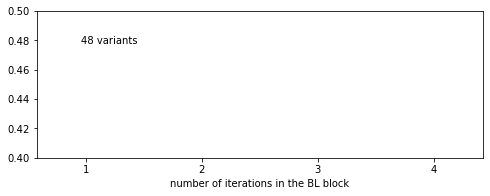

[0.25953662266121885, 0.2650429269500531, 0.27606101386658594, 0.283402377265771] [2.12159048 4.15709525 2.65932639]


,num_of_cycles,performance,gain %
0,1,0.259537,NaN
1,2,0.265043,2.121590
2,3,0.276061,4.157095
3,4,0.283402,2.659326


In [15]:
plot_step_increase(corr_mean_8k.xs('quarter', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))
plot_step_increase(corr_mean_8k.xs('quarter', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))
plot_step_increase(corr_mean_8k.xs('quarter', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))

In [16]:
# check relationship between num_param and performance, colored for different num_of_cycles.

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.010792412652047481 sem 0.0011044108242064718
3 - 2 mean 0.0016585113082303645 sem 0.0008219722668010903
4 - 3 mean -0.0009681694745051038 sem 0.000744792392878882
4 - 2 mean 0.0006903418337252607 sem 0.0008013561601805311


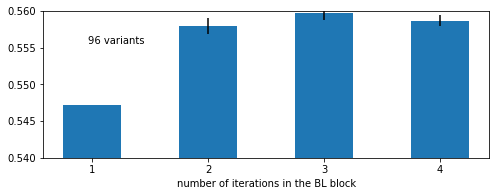

[0.5472008383148222, 0.5579932509668697, 0.5596517622751002, 0.558683592800595] [ 1.97229461  0.29722784 -0.17299498]


,num_of_cycles,performance,gain %
0,1,0.547201,NaN
1,2,0.557993,1.972295
2,3,0.559652,0.297228
3,4,0.558684,-0.172995


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.0097842758150005 sem 0.0016257646609506148
3 - 2 mean 0.0025875030607990248 sem 0.001311050565825802
4 - 3 mean -0.002665244752521695 sem 0.000994338813048486
4 - 2 mean -7.774169172267027e-05 sem 0.0012454196893882663


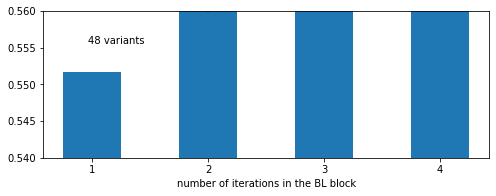

[0.5517267559799682, 0.5615110317949686, 0.5640985348557678, 0.561433290103246] [ 1.77339158  0.46081073 -0.47247858]


,num_of_cycles,performance,gain %
0,1,0.551727,NaN
1,2,0.561511,1.773392
2,3,0.564099,0.460811
3,4,0.561433,-0.472479


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.011800549489094465 sem 0.0014810249311236047
3 - 2 mean 0.0007295195556617043 sem 0.0009735197174312786
4 - 3 mean 0.0007289058035114872 sem 0.0010536367834113282
4 - 2 mean 0.0014584253591731916 sem 0.0009965115318960535


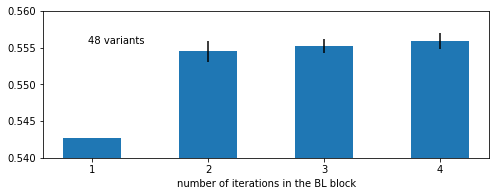

[0.5426749206496763, 0.5544754701387707, 0.5552049896944324, 0.5559338954979439] [2.17451536 0.13156931 0.13128589]


,num_of_cycles,performance,gain %
0,1,0.542675,NaN
1,2,0.554475,2.174515
2,3,0.555205,0.131569
3,4,0.555934,0.131286


In [17]:
plot_step_increase(corr_mean_cb19.xs('full', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))
plot_step_increase(corr_mean_cb19.xs('full', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))
plot_step_increase(corr_mean_cb19.xs('full', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.01688876755807643 sem 0.002057310257414483
3 - 2 mean 0.004753346176082575 sem 0.0013377988197450206
4 - 3 mean 0.0019430408570522747 sem 0.0012086502380151871
4 - 2 mean 0.00669638703313485 sem 0.0018018925282820492


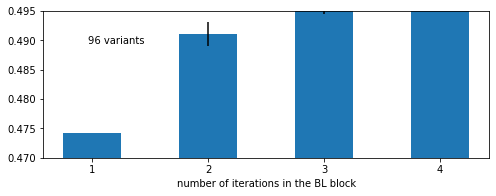

[0.474138823147396, 0.4910275907054724, 0.49578093688155506, 0.4977239777386073] [3.56198791 0.96804055 0.3919152 ]


,num_of_cycles,performance,gain %
0,1,0.474139,NaN
1,2,0.491028,3.561988
2,3,0.495781,0.968041
3,4,0.497724,0.391915


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.017046756725591052 sem 0.0025165745268436505
3 - 2 mean 0.003965601587510189 sem 0.0017040341541174255
4 - 3 mean 0.0025436477721019397 sem 0.001576812866082505
4 - 2 mean 0.006509249359612129 sem 0.0019586999695014717


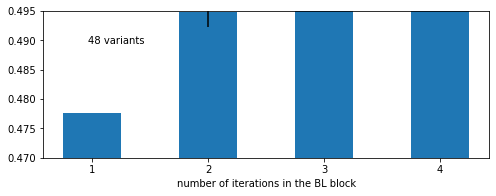

[0.47769324375459626, 0.49474000048018724, 0.4987056020676975, 0.5012492498397995] [3.56855722 0.80155265 0.51004997]


,num_of_cycles,performance,gain %
0,1,0.477693,NaN
1,2,0.494740,3.568557
2,3,0.498706,0.801553
3,4,0.501249,0.510050


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.01673077839056181 sem 0.0032551366496430243
3 - 2 mean 0.00554109076465496 sem 0.0020565102559137113
4 - 3 mean 0.0013424339420026095 sem 0.0018281062375237176
4 - 2 mean 0.00688352470665757 sem 0.003024781310362919


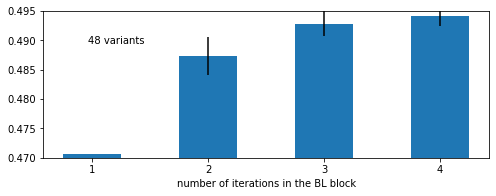

[0.4705844025401958, 0.48731518093075765, 0.4928562716954126, 0.49419870563741514] [3.55531936 1.13706508 0.27237838]


,num_of_cycles,performance,gain %
0,1,0.470584,NaN
1,2,0.487315,3.555319
2,3,0.492856,1.137065
3,4,0.494199,0.272378


In [18]:
plot_step_increase(corr_mean_cb19.xs('half', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))
plot_step_increase(corr_mean_cb19.xs('half', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))
plot_step_increase(corr_mean_cb19.xs('half', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.0021227990738076226 sem 0.004507594981304108
3 - 2 mean 0.010707427872747888 sem 0.002361848505894802
4 - 3 mean 0.0067355149065054356 sem 0.002453435840750117
4 - 2 mean 0.017442942779253325 sem 0.002935496721959018


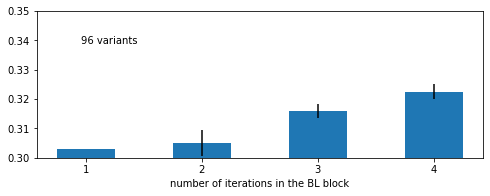

[0.30298710756673175, 0.30510990664053933, 0.31581733451328725, 0.3225528494197927] [0.70062356 3.50936749 2.13272489]


,num_of_cycles,performance,gain %
0,1,0.302987,NaN
1,2,0.305110,0.700624
2,3,0.315817,3.509367
3,4,0.322553,2.132725


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.0008892731206620723 sem 0.007158248253645265
3 - 2 mean 0.00812138017130301 sem 0.0030711925018624517
4 - 3 mean 0.006907383410716429 sem 0.0028236016625681312
4 - 2 mean 0.015028763582019438 sem 0.0032142363394340196


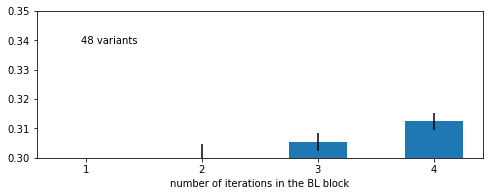

[0.2965056596969824, 0.29739493281764456, 0.3055163129889475, 0.312423696399664] [0.29991776 2.73084013 2.26088857]


,num_of_cycles,performance,gain %
0,1,0.296506,NaN
1,2,0.297395,0.299918
2,3,0.305516,2.730840
3,4,0.312424,2.260889


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.003356325026953172 sem 0.0054744618523544925
3 - 2 mean 0.013293475574192767 sem 0.0035499913092763625
4 - 3 mean 0.0065636464022944445 sem 0.004012908243062289
4 - 2 mean 0.019857121976487212 sem 0.004888190315062975


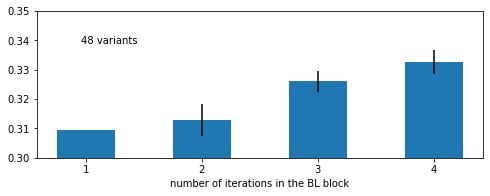

[0.30946855543648105, 0.3128248804634342, 0.326118356037627, 0.33268200243992135] [1.08454477 4.24949434 2.01265776]


,num_of_cycles,performance,gain %
0,1,0.309469,NaN
1,2,0.312825,1.084545
2,3,0.326118,4.249494
3,4,0.332682,2.012658


In [20]:
plot_step_increase(corr_mean_cb19.xs('quarter', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))
plot_step_increase(corr_mean_cb19.xs('quarter', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))
plot_step_increase(corr_mean_cb19.xs('quarter', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))